# PCA-Based Image Denoising on MNIST

This notebook demonstrates Principal Component Analysis (PCA) for dimensionality reduction and image denoising using the MNIST handwritten digits dataset.

**Contents:**
- Eigendecomposition implementation from scratch
- PCA reconstruction at various component counts
- Noisy data generation
- Image denoising using PCA


In [3]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

### Data setup: (Provided for you)
We are using the MNIST dataset from [Pytorch](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html). For the sake of simplicity, we are only using only the first 2000 samples from the test set. Here, we have normalized the images to the range [0, 1], then reshaped each image to a tensor vector of size 784 and stack them together to get an array of 2000x784.

In [2]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract the first 2000 samples
data = mnist_data.data[:2000].float()
labels = mnist_data.targets[:2000]

# Normalize the data to [0, 1]
data /= 255.0

# Reshape the data
n, d = data.size(0), data.size(1) * data.size(2)  # n = 2000, d = 784
X = data.view(n, d)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.22MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.29MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### a. Eigendecomposition Implementation: `eigen_decomp()`. Take care to:- Center the input data `X` by subtracting the mean of each feature.- Calculate the covariance matrix and performs eigendecomposition to obtain eigenvalues and eigenvectors.- Compute the cumulative variance explained by each component and return it.ii.   Plot the cumulative explained variance against the number of principal components.

In [4]:
def eigen_decomp(X):
    """
    Performs eigendecomposition on the covariance matrix of the input data `X`.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features.

    Returns:
        tuple: A tuple containing:
            - eigvals (torch.Tensor): Eigenvalues of the covariance matrix, representing variance explained by each principal component.
            - eigvecs (torch.Tensor): Eigenvectors of the covariance matrix, each representing a principal component direction.
            - cumulative_variance_explained (np.ndarray): Cumulative variance explained by each principal component, as a numpy array.
    """
    # Step 1: Center the data by subtracting the mean of each feature
    X_centered = X - X.mean(dim=0)

    # Step 2: Compute the covariance matrix
    covariance_matrix = torch.matmul(X_centered.T, X_centered) / (X.size(0) - 1)

    # Step 3: Perform eigendecomposition on the covariance matrix
    eigvals, eigvecs = torch.linalg.eigh(covariance_matrix)

    # Step 4: Sort eigenvalues and eigenvectors in descending order
    sorted_indices = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    # Step 5: Compute the cumulative variance explained
    total_variance = eigvals.sum()
    cumulative_variance_explained = torch.cumsum(eigvals, dim=0) / total_variance
    cumulative_variance_explained = cumulative_variance_explained.numpy()  # Convert to numpy array

    return eigvals, eigvecs, cumulative_variance_explained


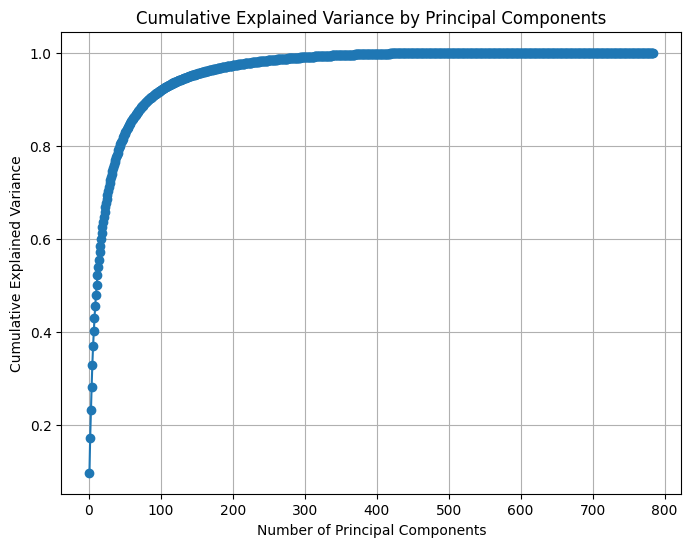

In [5]:
eigvals, eigvecs, cumulative_variance_explained = eigen_decomp(X)

# Plot the cumulative variance against the principal components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid()
plt.show()


### Analysis Q: What do you think happens when we reduce the number of principal components $p$?

### AnswerWhen we reduce the number of principal components𝑝p, we are essentially choosing to retain only the top𝑝p components that explain the most variance in the data. Here’s what happens in this case:Dimensionality Reduction: By reducing𝑝p, we reduce the number of dimensions of the data, which can simplify computations and make models faster, especially with large datasets.Information Loss: If𝑝p is much smaller than the original number of features, some information or variance in the data is lost. This loss depends on how much variance the discarded components explain. If the cumulative explained variance of the retained components is high (e.g., 95% or above), the information loss might be minimal.Noise Reduction: Often, the lower-ranked principal components capture noise rather than meaningful signal. By reducing𝑝p, we discard these noise-dominated components, potentially improving model performance, especially in cases with high-dimensional data or noise.Better Generalization: In machine learning, using a smaller𝑝p can prevent overfitting by focusing on the primary structure in the data rather than noise. This can lead to models that generalize better to new data.Interpretability: With fewer dimensions, data becomes easier to visualize and interpret, especially when reducing𝑝p to 2 or 3 for plotting or other exploratory data analysis.

### b. PCA Implementation:- Center the input data `X` by subtracting the mean of each feature (again).- Projects `X` onto the top `p` principal components, reconstructs it.- Compute the normalized reconstruction error in terms of the Frobenius norm, i.e. $e_{p} = \frac{\|x - \hat{x}_p\|_{F}}{\|x\|_{F}}$, where $x$ denotes the input matrix and $\hat{x}_p$ denotes the recovered matrix associated to each $p$.

In [6]:
def pca_reconstruction_error(X, p, eigvecs):
    """
    Calculates the PCA reconstruction error for the given data `X` using the top `p` principal components.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features.
        p (int): The number of principal components to use for reconstruction.
        eigvecs (torch.Tensor): Eigenvectors obtained from PCA, with each column representing a principal component direction.

    Returns:
        tuple: A tuple containing:
            - error (float): The normalized Frobenius norm of the difference between `X` and its PCA reconstruction, representing the reconstruction error.
            - X_reconstructed (torch.Tensor): The reconstructed data using `p` principal components.
    """
    # Step 1: Center the data
    X_centered = X - X.mean(dim=0)

    # Step 2: Select the top p eigenvectors
    top_p_eigvecs = eigvecs[:, :p]

    # Step 3: Project the data onto the top p principal components
    X_projected = torch.matmul(X_centered, top_p_eigvecs)

    # Step 4: Reconstruct the data from the top p components
    X_reconstructed = torch.matmul(X_projected, top_p_eigvecs.T)

    # Step 5: Compute the Frobenius norm of the reconstruction error
    # Note: The error is normalized by the Frobenius norm of the centered original data
    reconstruction_error = torch.norm(X_centered - X_reconstructed, p='fro') / torch.norm(X_centered, p='fro')

    return reconstruction_error.item(), X_reconstructed


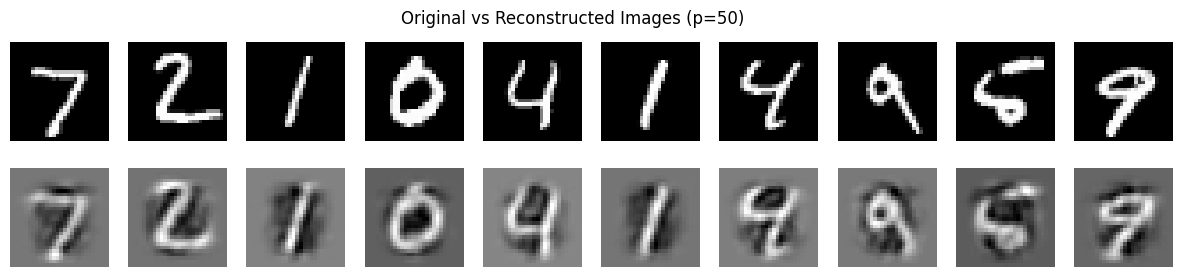

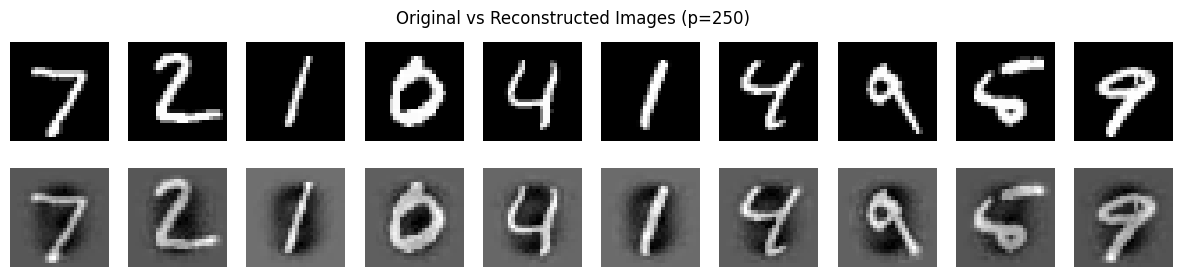

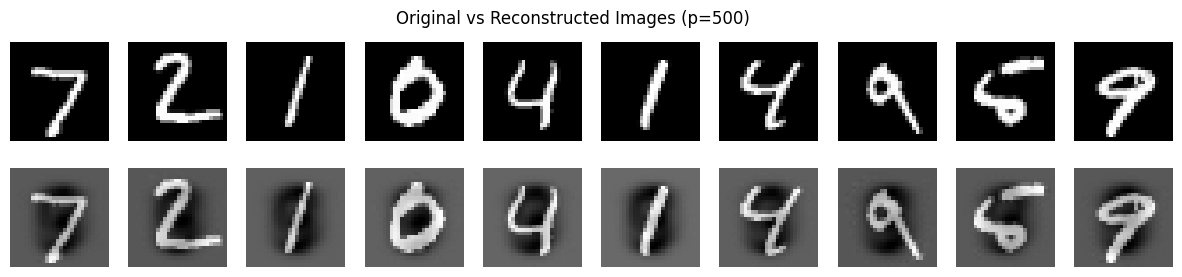

Frobenius Norm Errors: [0.41775909066200256, 0.12825925648212433, 0.01555741298943758]


In [7]:
### Driver code for the previousky defined functions
frobenius_norm = []

# Evaluate for p = 50, 250, 500
for p in [50, 250, 500]:
    error, X_reconstructed = pca_reconstruction_error(X, p, eigvecs)
    frobenius_norm.append(error)

    # Visualize some original and reconstructed images
    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(f'Original vs Reconstructed Images (p={p})')
    plt.show()

print(f"Frobenius Norm Errors: {frobenius_norm}")

### c. Noisy Data Generation Implementation: `mnist_noised()` to generate noisy versions of the mnist data.Visualization: the noisy images and compare them with their corresponding original images.iii.   Plot the cumulative explained variance of the **noisy data** along with the **original data** versus the number of components.

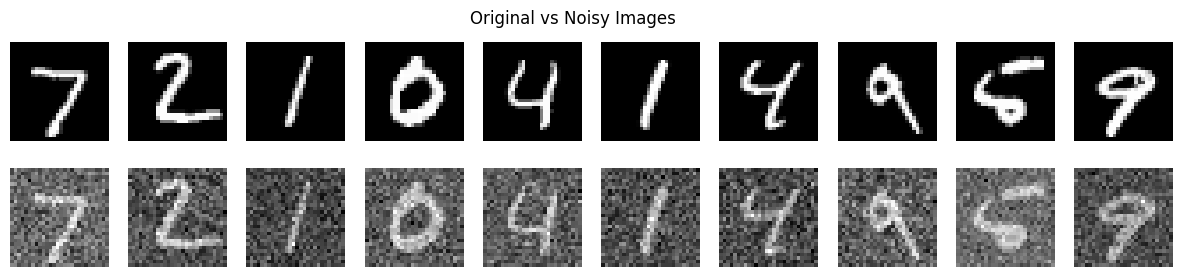

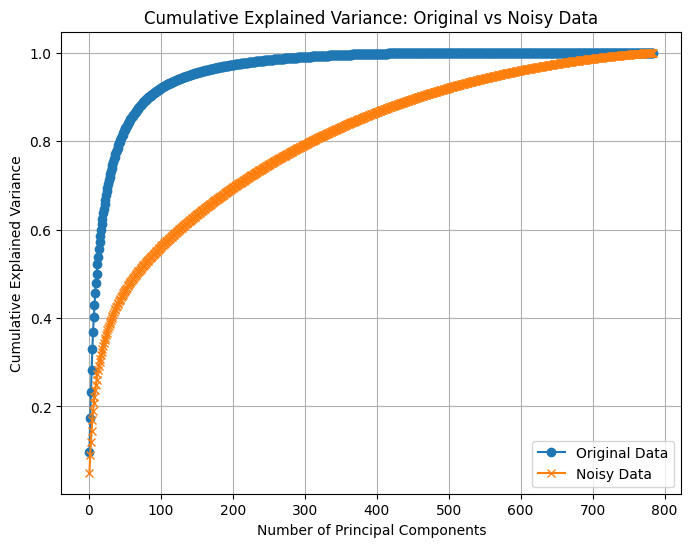

In [8]:
# Add Gaussian noise
def mnist_noised(X, noise_var=0.25):
    """
    Adds Gaussian noise to the input data `X`.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features (e.g., flattened images).
        noise_var (float, optional): The variance of the Gaussian noise to be added. Default is 0.25.

    Returns:
        torch.Tensor: A tensor with Gaussian noise added to each element of `X`.
    """
    noise = torch.randn(X.size()) * noise_var
    return X + noise

# Add Gaussian noise to the data
noisy_data = mnist_noised(X)

# Plot some original and noisy images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_data[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.suptitle('Original vs Noisy Images')
plt.show()

# Compute eigen decomposition for the noisy data
eigvals_noisy, eigvecs_noisy, cumulative_variance_explained_noisy = eigen_decomp(noisy_data)

# Plot the cumulative variance for noisy data and original data
##TODO##
# Compute eigen decomposition for the noisy data
eigvals_noisy, eigvecs_noisy, cumulative_variance_explained_noisy = eigen_decomp(noisy_data)

# Compute eigen decomposition for the original data (if not already done)
eigvals_original, eigvecs_original, cumulative_variance_explained_original = eigen_decomp(X)

# Plot cumulative variance for both noisy and original data
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_explained_original) + 1), cumulative_variance_explained_original, label='Original Data', marker='o')
plt.plot(range(1, len(cumulative_variance_explained_noisy) + 1), cumulative_variance_explained_noisy, label='Noisy Data', marker='x')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance: Original vs Noisy Data')
plt.legend()
plt.grid()
plt.show()


### Analysis Q: How do the 2 plots compare? Are they similar?A: No they are not similar. In the plot for original data the variance in concentrated in first few principal components   leading to faster accumulation. Thus the plot reaches true variance only with few number of components. While for noisy data   it takes a lot of principal components to give a true estimate of variance.

### Analysis

The comparison between the two plots shows significant differences in variance distribution.


### d. Image Denoising i.   Implementation:- Add Gaussian noise of a specified variance ($\sigma^{2}$) to the original data.- Compute the eigen decomposition on the noisy data, retaining only the top `p` principal components.- Calculate the reconstruction error to quantify the quality of denoising.ii. Plot the denoised images agianst the noisy data for visual comparison.

In [11]:
def pca_reconstruction_noisy(X, noise_var=0.05, p=100):
    """
    Adds Gaussian noise to input data `X`, performs PCA-based dimensionality reduction,
    and reconstructs the denoised images using the top `p` principal components.

    Args:
        X (torch.Tensor): A 2D tensor where rows represent samples and columns represent features (e.g., flattened images).
        noise_var (float, optional): Variance of the Gaussian noise to be added to `X`. Default is 0.05.
        p (int, optional): Number of principal components to retain for PCA-based reconstruction. Default is 100.

    Returns:
        tuple: A tuple containing:
            - error (float): The normalized reconstruction error after applying PCA to the noisy data.
            - X_reconstructed (torch.Tensor): A 2D tensor of reconstructed data using the top `p` components, representing the denoised images.
    """
    # Step 1: Add Gaussian noise to the original data
    X_noisy = mnist_noised(X, noise_var=noise_var)

    # Step 2: Compute eigen decomposition on the noisy data
    eigvals_noisy, eigvecs_noisy, _ = eigen_decomp(X_noisy)

    # Step 3: Perform PCA reconstruction with top `p` components
    error, X_reconstructed = pca_reconstruction_error(X_noisy, p, eigvecs_noisy)

    return error, X_reconstructed

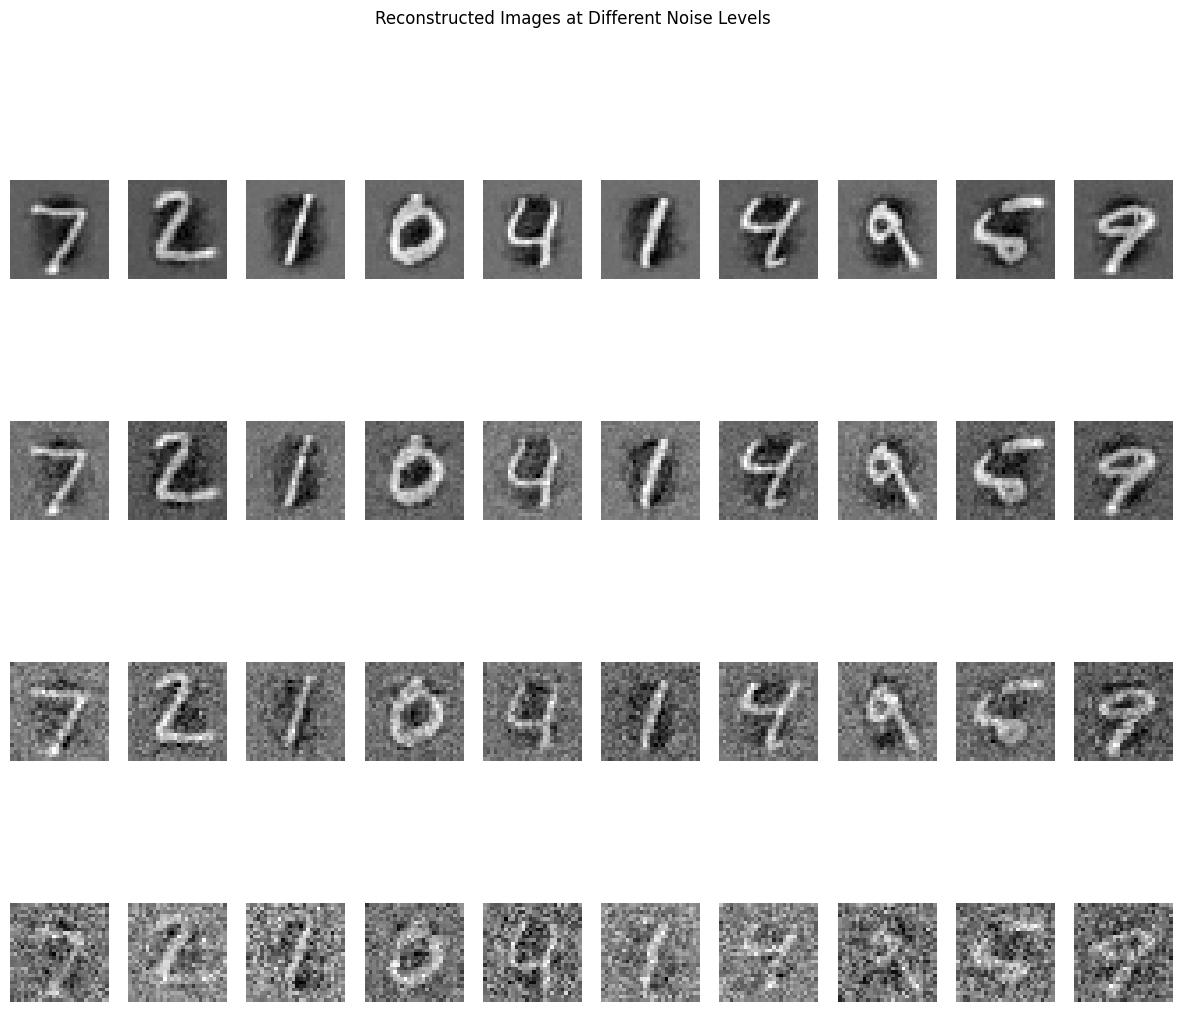

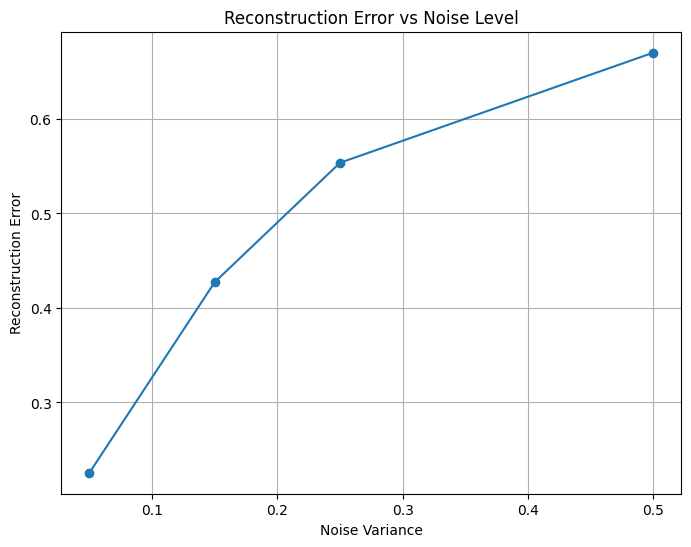

Reconstruction Errors for different noise levels: [0.2256140410900116, 0.4272291958332062, 0.5535377860069275, 0.6700105667114258]


In [12]:
### Driver code for the previousky defined functions
noise_levels = [0.05, 0.15, 0.25, 0.5]
errors = []

# Set up plotting to display original, noisy, and reconstructed images for each noise level
fig, axes = plt.subplots(len(noise_levels), 10, figsize=(15, 3 * len(noise_levels)))

# Iterate over each noise level, compute reconstruction, and plot
for idx, noise_var in enumerate(noise_levels):
    # Perform PCA-based denoising with the specified noise variance
    error, X_reconstructed = pca_reconstruction_noisy(X, noise_var, p=200)
    errors.append(error)

    # Plot original vs noisy vs reconstructed for a few samples (top 10 samples)
    for i in range(10):
        # Plot the reconstructed images for the current noise level
        axes[idx, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[idx, i].axis('off')

    # Label the row with the current noise level
    axes[idx, 0].set_ylabel(f"Noise {noise_var}", rotation=0, labelpad=35, fontsize=10)

plt.suptitle('Reconstructed Images at Different Noise Levels')
plt.show()

# Plot reconstruction errors vs noise levels
plt.figure(figsize=(8, 6))
plt.plot(noise_levels, errors, marker='o')
plt.xlabel('Noise Variance')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Noise Level')
plt.grid()
plt.show()

print(f"Reconstruction Errors for different noise levels: {errors}")